# Análisis de Machine Learning - League of Legends
## Metodología CRISP-DM

**Proyecto:** Predicción de Resultados y Duración de Partidas de League of Legends

**Autor:** Análisis Completo

**Fecha:** 2025

---

## Tabla de Contenidos

1. [Comprensión del Negocio](#1-comprension-del-negocio)
2. [Comprensión de los Datos](#2-comprension-de-los-datos)
3. [Preparación de los Datos](#3-preparacion-de-los-datos)
4. [Modelado - Regresión](#4-modelado-regresion)
5. [Modelado - Clasificación](#5-modelado-clasificacion)
6. [Evaluación](#6-evaluacion)
7. [Conclusiones](#7-conclusiones)


# 1. Comprensión del Negocio

## 1.1 Objetivos del Negocio

**Contexto:** League of Legends es un juego multijugador online de batalla en arena (MOBA) donde dos equipos de 5 jugadores compiten. Cada equipo tiene una base que debe defender mientras intenta destruir la base enemiga.

**Objetivos:**
- Predecir la duración de una partida basándose en características del juego (problema de **regresión**)
- Predecir qué equipo ganará la partida basándose en eventos tempranos del juego (problema de **clasificación**)

## 1.2 Objetivos de Machine Learning

### Problema de Regresión
- **Variable objetivo:** `gamelength` (duración del juego en minutos)
- **Métricas:** RMSE, MAE, R²

### Problema de Clasificación
- **Variable objetivo:** `bResult` (resultado del equipo azul: 1=Victoria, 0=Derrota)
- **Métricas:** Accuracy, Precision, Recall, F1-Score, AUC-ROC

## 1.3 Plan de Proyecto

Seguiremos la metodología **CRISP-DM** con las siguientes fases:
1. Comprensión del negocio ✓
2. Comprensión de los datos
3. Preparación de los datos
4. Modelado
5. Evaluación
6. Despliegue/Conclusiones


In [1]:
# Importación de librerías necesarias

# Manipulación de datos
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Métricas y preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Modelos de Regresión
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Modelos de Clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Métricas de evaluación
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                            accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, roc_curve, confusion_matrix,
                            classification_report)

# Utilidades
from scipy import stats
from datetime import datetime

print("✓ Librerías importadas correctamente")
print(f"Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Librerías importadas correctamente
Fecha de ejecución: 2025-10-27 00:02:32


# 2. Comprensión de los Datos

## 2.1 Carga de Datos

Los datos provienen de múltiples archivos CSV que contienen información detallada de partidas profesionales de League of Legends:

- **matchinfo.csv**: Información general de cada partida (equipos, jugadores, campeones, resultado, duración)
- **kills.csv**: Detalles de cada eliminación en las partidas
- **gold.csv**: Diferencia de oro minuto a minuto
- **bans.csv**: Campeones baneados por cada equipo
- **monsters.csv**: Objetivos neutros capturados (dragones, barones)
- **structures.csv**: Destrucción de torres y estructuras


In [2]:
# Carga de los datos
data_path = '../data/01_raw/'

# Cargar archivo principal de partidas
df_matches = pd.read_csv(data_path + 'matchinfo.csv')
df_kills = pd.read_csv(data_path + 'kills.csv')
df_gold = pd.read_csv(data_path + 'gold.csv')
df_bans = pd.read_csv(data_path + 'bans.csv')
df_monsters = pd.read_csv(data_path + 'monsters.csv')
df_structures = pd.read_csv(data_path + 'structures.csv')

print("="*60)
print("DATOS CARGADOS EXITOSAMENTE")
print("="*60)
print(f"\n📊 Partidas: {df_matches.shape[0]:,} filas x {df_matches.shape[1]} columnas")
print(f"⚔️  Kills: {df_kills.shape[0]:,} filas x {df_kills.shape[1]} columnas")
print(f"💰 Gold: {df_gold.shape[0]:,} filas x {df_gold.shape[1]} columnas")
print(f"🚫 Bans: {df_bans.shape[0]:,} filas x {df_bans.shape[1]} columnas")
print(f"🐉 Monsters: {df_monsters.shape[0]:,} filas x {df_monsters.shape[1]} columnas")
print(f"🏰 Structures: {df_structures.shape[0]:,} filas x {df_structures.shape[1]} columnas")


DATOS CARGADOS EXITOSAMENTE

📊 Partidas: 7,620 filas x 30 columnas
⚔️  Kills: 191,069 filas x 11 columnas
💰 Gold: 99,060 filas x 97 columnas
🚫 Bans: 15,240 filas x 7 columnas
🐉 Monsters: 44,248 filas x 4 columnas
🏰 Structures: 121,386 filas x 5 columnas


## 2.2 Exploración Inicial de Datos (EDA)

### 2.2.1 Estructura del Dataset Principal


In [3]:
# Visualizar primeras filas del dataset principal
print("="*80)
print("VISTA PRELIMINAR DE LOS DATOS")
print("="*80)
df_matches.head(10)


VISTA PRELIMINAR DE LOS DATOS


,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,blueTop,...,redTopChamp,redJungle,redJungleChamp,redMiddle,redMiddleChamp,redADC,redADCChamp,redSupport,redSupportChamp,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,Dyrus,...,Gnar,Meteos,Elise,Hai,Fizz,Sneaky,Sivir,LemonNation,Thresh,http://matchhistory.na.leagueoflegends.com/en/...
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,Cris,...,Irelia,Crumbzz,JarvanIV,Shiphtur,Azir,CoreJJ,Corki,KiWiKiD,Annie,http://matchhistory.na.leagueoflegends.com/en/...
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,Flaresz,...,Sion,Saintvicious,LeeSin,Keane,Azir,Cop,Corki,BunnyFuFuu,Janna,http://matchhistory.na.leagueoflegends.com/en/...
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,Rhux,...,Gnar,IWDominate,Nunu,Fenix,Lulu,KEITH,KogMaw,Xpecial,Janna,http://matchhistory.na.leagueoflegends.com/en/...
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,Benny,...,Sion,Porpoise8,RekSai,Slooshi8,Lulu,Maplestreet8,Corki,Dodo8,Annie,http://matchhistory.na.leagueoflegends.com/en/...
5,NALCS,2015,Spring,Season,DIG,0,1,TIP,24,Gamsu,...,Gnar,Rush,JarvanIV,XiaoWeiXiao,Lulu,Apollo,Corki,Adrian,Thresh,http://matchhistory.na.leagueoflegends.com/en/...
6,NALCS,2015,Spring,Season,CST,1,0,WFX,39,Cris,...,Renekton,ShorterACE,LeeSin,Pobelter,Leblanc,Altec,Tristana,Gleeb,Nami,http://matchhistory.na.leagueoflegends.com/en/...
7,NALCS,2015,Spring,Season,TL,1,0,CLG,43,Quas,...,Rumble,Xmithie,Rengar,Link,Leblanc,Doublelift,Sivir,Aphromoo,Blitzcrank,http://matchhistory.na.leagueoflegends.com/en/...
8,NALCS,2015,Spring,Season,C9,0,1,GV,41,Balls,...,Kassadin,Saintvicious,Vi,Keane,Zed,Cop,Corki,Bunny FuFuu,Morgana,http://matchhistory.na.leagueoflegends.com/en/...
9,NALCS,2015,Spring,Season,T8,1,0,TSM,32,CaliTrlolz8,...,Gnar,Santorin,Rengar,Bjergsen,Leblanc,WildTurtle,Graves,Lustboy,Morgana,http://matchhistory.na.leagueoflegends.com/en/...


In [4]:
# Información general del dataset
print("\n" + "="*80)
print("INFORMACIÓN DEL DATASET")
print("="*80)
df_matches.info()



INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   League            7620 non-null   object
 1   Year              7620 non-null   int64 
 2   Season            7620 non-null   object
 3   Type              7620 non-null   object
 4   blueTeamTag       7582 non-null   object
 5   bResult           7620 non-null   int64 
 6   rResult           7620 non-null   int64 
 7   redTeamTag        7583 non-null   object
 8   gamelength        7620 non-null   int64 
 9   blueTop           7583 non-null   object
 10  blueTopChamp      7620 non-null   object
 11  blueJungle        7592 non-null   object
 12  blueJungleChamp   7620 non-null   object
 13  blueMiddle        7583 non-null   object
 14  blueMiddleChamp   7620 non-null   object
 15  blueADC           7583 non-null   object
 16  blueADCChamp      7620 non-null   o

### 2.2.2 Análisis de Valores Faltantes (Missing Values)

**Justificación técnica:** Es crucial identificar valores faltantes ya que pueden introducir sesgos en el modelo o causar errores durante el entrenamiento. La estrategia de tratamiento dependerá del porcentaje de valores faltantes y la naturaleza de la variable.


ANÁLISIS DE VALORES FALTANTES

⚠️  Se encontraron valores faltantes en 12 columnas:

             Total_Missing  Percentage
blueTeamTag             38        0.50
redTeamTag              37        0.49
blueTop                 37        0.49
blueMiddle              37        0.49
redMiddle               37        0.49
blueADC                 37        0.49
blueSupport             37        0.49
redTop                  37        0.49
redSupport              37        0.49
redADC                  37        0.49
blueJungle              28        0.37
redJungle               24        0.31


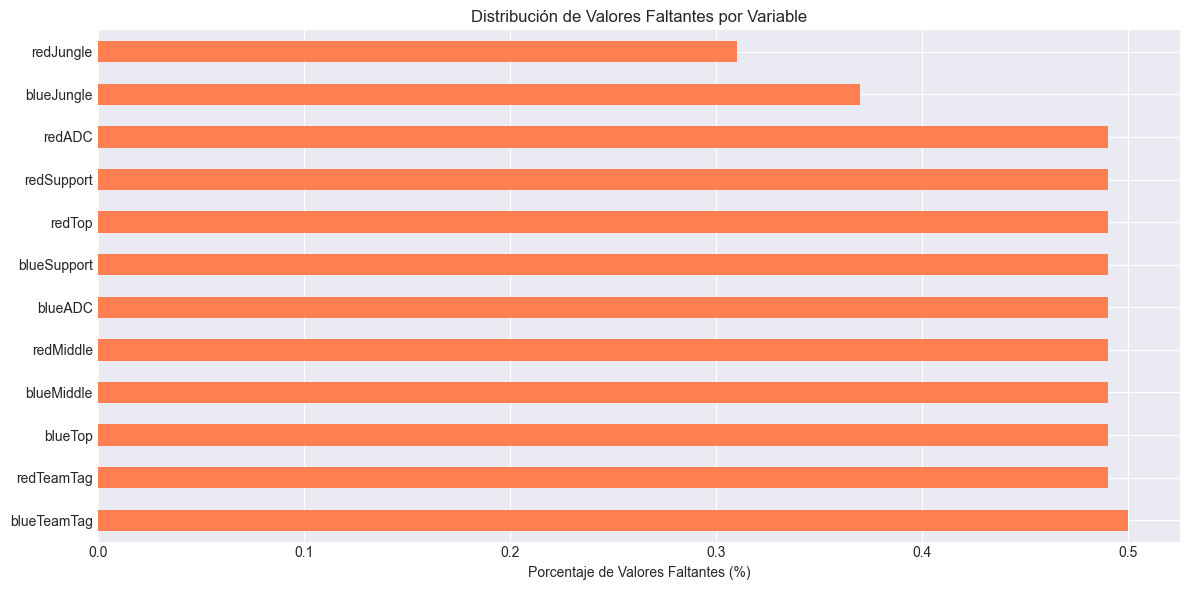

In [5]:
# Análisis de valores faltantes
print("="*80)
print("ANÁLISIS DE VALORES FALTANTES")
print("="*80)

missing_data = pd.DataFrame({
    'Total_Missing': df_matches.isnull().sum(),
    'Percentage': (df_matches.isnull().sum() / len(df_matches) * 100).round(2)
})

missing_data = missing_data[missing_data['Total_Missing'] > 0].sort_values('Percentage', ascending=False)

if len(missing_data) > 0:
    print(f"\n⚠️  Se encontraron valores faltantes en {len(missing_data)} columnas:\n")
    print(missing_data)
    
    # Visualización
    plt.figure(figsize=(12, 6))
    missing_data['Percentage'].plot(kind='barh', color='coral')
    plt.xlabel('Porcentaje de Valores Faltantes (%)')
    plt.title('Distribución de Valores Faltantes por Variable')
    plt.tight_layout()
    plt.show()
else:
    print("\n✓ No se encontraron valores faltantes en el dataset principal")


### 2.2.3 Estadísticos Descriptivos

**Justificación técnica:** Los estadísticos descriptivos nos permiten entender la distribución de las variables numéricas, identificar posibles outliers, y obtener insights sobre las medidas de tendencia central (media, mediana) y dispersión (desviación estándar, rango intercuartílico).


In [6]:
# Estadísticos descriptivos de la variable objetivo (duración del juego)
print("="*80)
print("ESTADÍSTICOS DESCRIPTIVOS - DURACIÓN DEL JUEGO (minutos)")
print("="*80)

gamelength_stats = df_matches['gamelength'].describe()
print(gamelength_stats)

# Estadísticos adicionales
print(f"\n📊 Medidas adicionales:")
print(f"   - Varianza: {df_matches['gamelength'].var():.2f}")
print(f"   - Coeficiente de variación: {(df_matches['gamelength'].std() / df_matches['gamelength'].mean() * 100):.2f}%")
print(f"   - Asimetría (Skewness): {df_matches['gamelength'].skew():.2f}")
print(f"   - Curtosis: {df_matches['gamelength'].kurtosis():.2f}")

# Distribución de resultados
print("\n" + "="*80)
print("DISTRIBUCIÓN DE RESULTADOS (Equipo Azul)")
print("="*80)
result_counts = df_matches['bResult'].value_counts()
print(f"\nVictorias: {result_counts[1]:,} ({result_counts[1]/len(df_matches)*100:.2f}%)")
print(f"Derrotas: {result_counts[0]:,} ({result_counts[0]/len(df_matches)*100:.2f}%)")


ESTADÍSTICOS DESCRIPTIVOS - DURACIÓN DEL JUEGO (minutos)
count    7620.000000
mean       37.012598
std         7.983238
min        17.000000
25%        31.000000
50%        36.000000
75%        41.000000
max        95.000000
Name: gamelength, dtype: float64

📊 Medidas adicionales:
   - Varianza: 63.73
   - Coeficiente de variación: 21.57%
   - Asimetría (Skewness): 0.93
   - Curtosis: 1.71

DISTRIBUCIÓN DE RESULTADOS (Equipo Azul)

Victorias: 4,146 (54.41%)
Derrotas: 3,474 (45.59%)


### 2.2.4 Visualización de Variables Objetivo


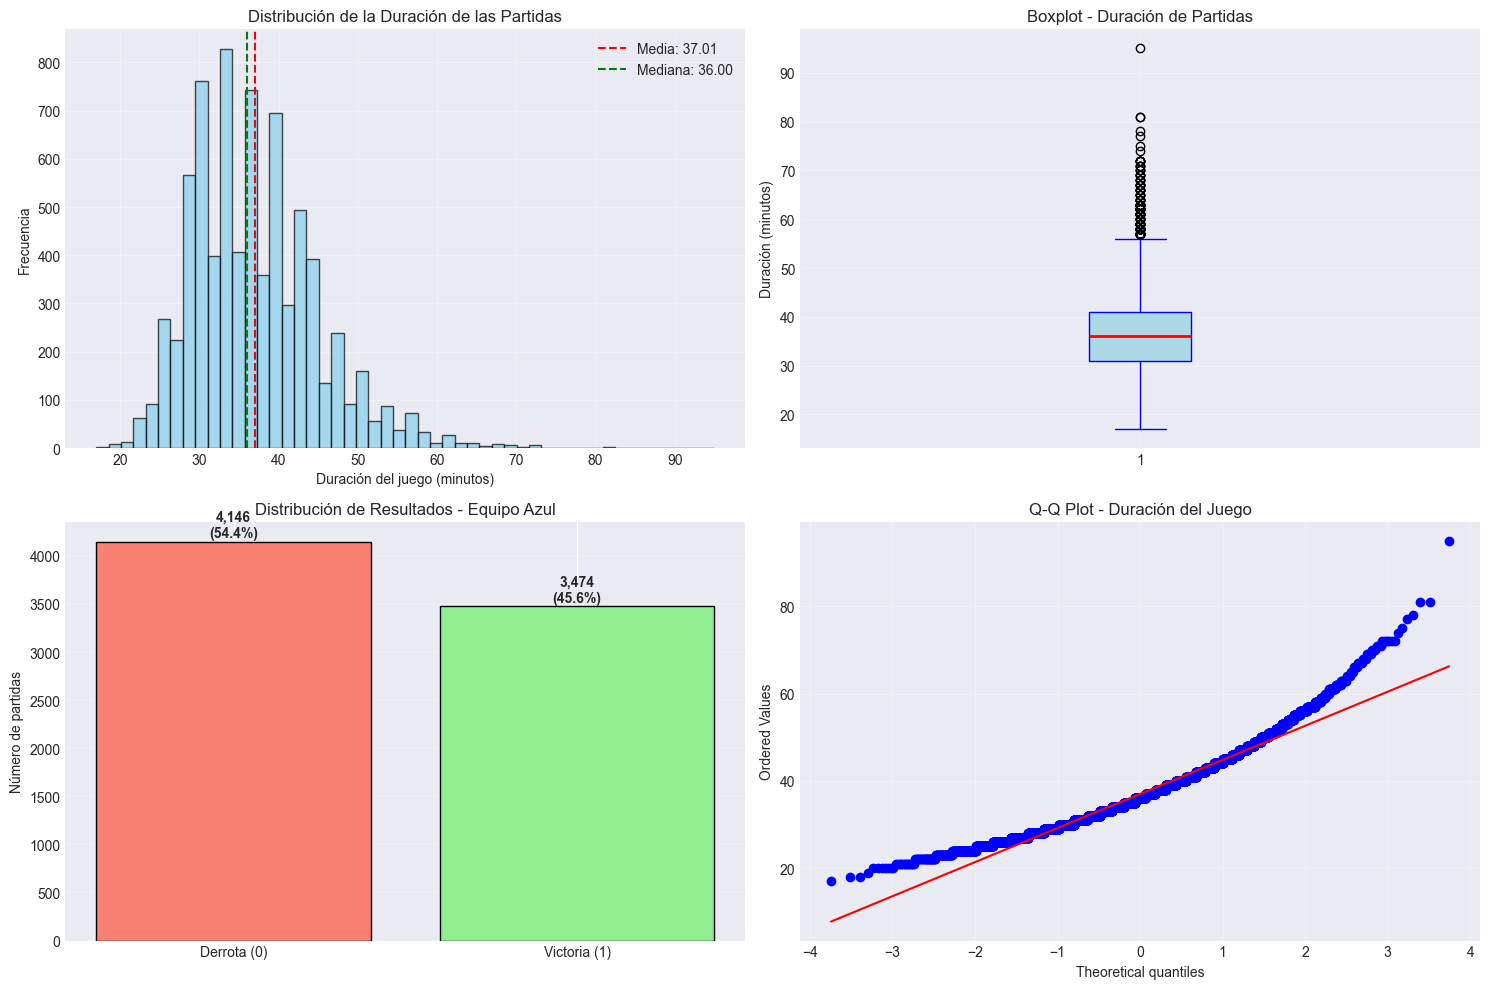

In [7]:
# Visualización de las variables objetivo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Histograma de duración del juego
axes[0, 0].hist(df_matches['gamelength'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df_matches['gamelength'].mean(), color='red', linestyle='--', label=f'Media: {df_matches["gamelength"].mean():.2f}')
axes[0, 0].axvline(df_matches['gamelength'].median(), color='green', linestyle='--', label=f'Mediana: {df_matches["gamelength"].median():.2f}')
axes[0, 0].set_xlabel('Duración del juego (minutos)')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribución de la Duración de las Partidas')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Boxplot de duración del juego
axes[0, 1].boxplot(df_matches['gamelength'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='blue'),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='blue'),
                   capprops=dict(color='blue'))
axes[0, 1].set_ylabel('Duración (minutos)')
axes[0, 1].set_title('Boxplot - Duración de Partidas')
axes[0, 1].grid(alpha=0.3)

# 3. Distribución de resultados (Clasificación)
result_counts = df_matches['bResult'].value_counts()
axes[1, 0].bar(['Derrota (0)', 'Victoria (1)'], result_counts.values, color=['salmon', 'lightgreen'], edgecolor='black')
axes[1, 0].set_ylabel('Número de partidas')
axes[1, 0].set_title('Distribución de Resultados - Equipo Azul')
axes[1, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate(result_counts.values):
    axes[1, 0].text(i, v + 50, f'{v:,}\n({v/len(df_matches)*100:.1f}%)', ha='center', fontweight='bold')

# 4. QQ-plot para normalidad
stats.probplot(df_matches['gamelength'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Duración del Juego')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 3. Preparación de los Datos

## 3.1 Feature Engineering

**Justificación técnica:** Crearemos features agregadas a partir de los diferentes datasets. Esto nos permitirá capturar información importante de kills, gold, objetivos y estructuras que son determinantes para predecir el resultado y la duración de las partidas.

### 3.1.1 Agregación de Features de Kills


In [8]:
# Agregar features de kills por partida
print("="*80)
print("FEATURE ENGINEERING - KILLS")
print("="*80)

# Contar kills por equipo
kills_blue = df_kills[df_kills['Team'] == 'bKills'].groupby('Address').size().reset_index(name='blue_kills')
kills_red = df_kills[df_kills['Team'] == 'rKills'].groupby('Address').size().reset_index(name='red_kills')

# Merge con el dataset principal
df_features = df_matches.copy()
df_features = df_features.merge(kills_blue, on='Address', how='left')
df_features = df_features.merge(kills_red, on='Address', how='left')

# Llenar NaN con 0 (partidas sin kills registrados)
df_features['blue_kills'] = df_features['blue_kills'].fillna(0)
df_features['red_kills'] = df_features['red_kills'].fillna(0)

# Crear feature de diferencia de kills
df_features['kill_diff'] = df_features['blue_kills'] - df_features['red_kills']

print(f"✓ Features de kills agregados")
print(f"   - blue_kills: Total de kills del equipo azul")
print(f"   - red_kills: Total de kills del equipo rojo")
print(f"   - kill_diff: Diferencia de kills (azul - rojo)")


FEATURE ENGINEERING - KILLS
✓ Features de kills agregados
   - blue_kills: Total de kills del equipo azul
   - red_kills: Total de kills del equipo rojo
   - kill_diff: Diferencia de kills (azul - rojo)


### 3.1.2 Agregación de Features de Objetivos (Dragones/Barones)


In [9]:
# Agregar features de objetivos (Dragones y Barones)
print("\n" + "="*80)
print("FEATURE ENGINEERING - OBJETIVOS (DRAGONES/BARONES)")
print("="*80)

# Dragones por equipo
dragons_blue = df_monsters[df_monsters['Team'] == 'bDragons'].groupby('Address').size().reset_index(name='blue_dragons')
dragons_red = df_monsters[df_monsters['Team'] == 'rDragons'].groupby('Address').size().reset_index(name='red_dragons')

# Barones por equipo
barons_blue = df_monsters[df_monsters['Team'] == 'bBarons'].groupby('Address').size().reset_index(name='blue_barons')
barons_red = df_monsters[df_monsters['Team'] == 'rBarons'].groupby('Address').size().reset_index(name='red_barons')

# Merge con el dataset de features
df_features = df_features.merge(dragons_blue, on='Address', how='left')
df_features = df_features.merge(dragons_red, on='Address', how='left')
df_features = df_features.merge(barons_blue, on='Address', how='left')
df_features = df_features.merge(barons_red, on='Address', how='left')

# Llenar NaN con 0
df_features['blue_dragons'] = df_features['blue_dragons'].fillna(0)
df_features['red_dragons'] = df_features['red_dragons'].fillna(0)
df_features['blue_barons'] = df_features['blue_barons'].fillna(0)
df_features['red_barons'] = df_features['red_barons'].fillna(0)

# Features de diferencia
df_features['dragon_diff'] = df_features['blue_dragons'] - df_features['red_dragons']
df_features['baron_diff'] = df_features['blue_barons'] - df_features['red_barons']

print(f"✓ Features de objetivos agregados")
print(f"   - blue_dragons, red_dragons, dragon_diff")
print(f"   - blue_barons, red_barons, baron_diff")



FEATURE ENGINEERING - OBJETIVOS (DRAGONES/BARONES)
✓ Features de objetivos agregados
   - blue_dragons, red_dragons, dragon_diff
   - blue_barons, red_barons, baron_diff


### 3.1.3 Agregación de Features de Estructuras (Torres)


In [10]:
# Agregar features de estructuras (Torres)
print("\n" + "="*80)
print("FEATURE ENGINEERING - ESTRUCTURAS (TORRES)")
print("="*80)

# Torres destruidas por equipo
towers_blue = df_structures[df_structures['Team'] == 'bTowers'].groupby('Address').size().reset_index(name='blue_towers')
towers_red = df_structures[df_structures['Team'] == 'rTowers'].groupby('Address').size().reset_index(name='red_towers')

# Inhibidores
inhibs_blue = df_structures[df_structures['Team'] == 'bInhibs'].groupby('Address').size().reset_index(name='blue_inhibs')
inhibs_red = df_structures[df_structures['Team'] == 'rInhibs'].groupby('Address').size().reset_index(name='red_inhibs')

# Merge
df_features = df_features.merge(towers_blue, on='Address', how='left')
df_features = df_features.merge(towers_red, on='Address', how='left')
df_features = df_features.merge(inhibs_blue, on='Address', how='left')
df_features = df_features.merge(inhibs_red, on='Address', how='left')

# Llenar NaN con 0
df_features['blue_towers'] = df_features['blue_towers'].fillna(0)
df_features['red_towers'] = df_features['red_towers'].fillna(0)
df_features['blue_inhibs'] = df_features['blue_inhibs'].fillna(0)
df_features['red_inhibs'] = df_features['red_inhibs'].fillna(0)

# Features de diferencia
df_features['tower_diff'] = df_features['blue_towers'] - df_features['red_towers']
df_features['inhib_diff'] = df_features['blue_inhibs'] - df_features['red_inhibs']

print(f"✓ Features de estructuras agregados")
print(f"   - blue_towers, red_towers, tower_diff")
print(f"   - blue_inhibs, red_inhibs, inhib_diff")



FEATURE ENGINEERING - ESTRUCTURAS (TORRES)
✓ Features de estructuras agregados
   - blue_towers, red_towers, tower_diff
   - blue_inhibs, red_inhibs, inhib_diff


### 3.1.4 Agregación de Features de Gold

**Justificación:** La diferencia de oro es un indicador clave del estado del juego. Extraeremos estadísticas en momentos específicos (minutos 10, 15, 20) que son puntos de inflexión típicos en una partida.


In [11]:
# Agregar features de gold difference
print("\n" + "="*80)
print("FEATURE ENGINEERING - DIFERENCIA DE ORO")
print("="*80)

# Obtener diferencia de gold en minutos específicos
df_gold_features = df_gold[df_gold['Type'] == 'golddiff'].copy()

# Extraer gold difference en minutos 10, 15, 20
gold_stats = []
for address in df_gold_features['Address'].unique():
    match_gold = df_gold_features[df_gold_features['Address'] == address]
    
    # Obtener valores en minutos específicos (si existen)
    gold_10 = match_gold['min_10'].values[0] if 'min_10' in match_gold.columns and len(match_gold) > 0 else np.nan
    gold_15 = match_gold['min_15'].values[0] if 'min_15' in match_gold.columns and len(match_gold) > 0 else np.nan
    gold_20 = match_gold['min_20'].values[0] if 'min_20' in match_gold.columns and len(match_gold) > 0 else np.nan
    
    gold_stats.append({
        'Address': address,
        'gold_diff_10': gold_10,
        'gold_diff_15': gold_15,
        'gold_diff_20': gold_20
    })

df_gold_agg = pd.DataFrame(gold_stats)

# Merge con features
df_features = df_features.merge(df_gold_agg, on='Address', how='left')

# Estrategia para missing values: Imputar con la mediana
# Justificación: La mediana es robusta a outliers
df_features['gold_diff_10'] = df_features['gold_diff_10'].fillna(df_features['gold_diff_10'].median())
df_features['gold_diff_15'] = df_features['gold_diff_15'].fillna(df_features['gold_diff_15'].median())
df_features['gold_diff_20'] = df_features['gold_diff_20'].fillna(df_features['gold_diff_20'].median())

print(f"✓ Features de gold agregados")
print(f"   - gold_diff_10: Diferencia de oro en minuto 10")
print(f"   - gold_diff_15: Diferencia de oro en minuto 15")
print(f"   - gold_diff_20: Diferencia de oro en minuto 20")



FEATURE ENGINEERING - DIFERENCIA DE ORO
✓ Features de gold agregados
   - gold_diff_10: Diferencia de oro en minuto 10
   - gold_diff_15: Diferencia de oro en minuto 15
   - gold_diff_20: Diferencia de oro en minuto 20


## 3.2 Detección y Tratamiento de Outliers

**Justificación técnica:** Los outliers pueden distorsionar los modelos de machine learning, especialmente los basados en distancias. Usaremos el método IQR (Rango Intercuartílico) para detectarlos y decidiremos su tratamiento según el contexto del negocio.


DETECCIÓN DE OUTLIERS - MÉTODO IQR

📊 Variable: gamelength (Duración del juego)
   - Límite inferior: 16.00
   - Límite superior: 56.00
   - Outliers detectados: 164 (2.15%)


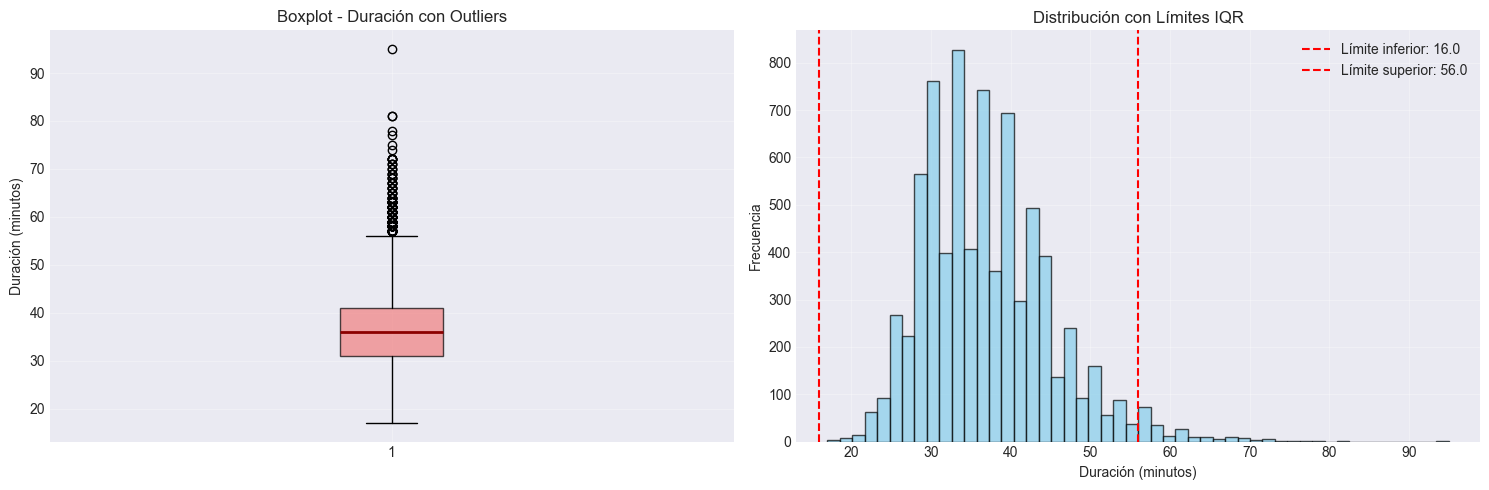


✓ DECISIÓN: Se mantienen los outliers
   Justificación: Las partidas muy largas o cortas son eventos legítimos
   del juego y contienen información valiosa para el modelo.


In [12]:
# Detección de outliers usando método IQR
print("="*80)
print("DETECCIÓN DE OUTLIERS - MÉTODO IQR")
print("="*80)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Analizar outliers en gamelength
outliers_gamelength, lower_gl, upper_gl = detect_outliers_iqr(df_features, 'gamelength')

print(f"\n📊 Variable: gamelength (Duración del juego)")
print(f"   - Límite inferior: {lower_gl:.2f}")
print(f"   - Límite superior: {upper_gl:.2f}")
print(f"   - Outliers detectados: {len(outliers_gamelength)} ({len(outliers_gamelength)/len(df_features)*100:.2f}%)")

# Visualización de outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot con outliers
axes[0].boxplot(df_features['gamelength'], vert=True, patch_artist=True,
               boxprops=dict(facecolor='lightcoral', alpha=0.7),
               medianprops=dict(color='darkred', linewidth=2))
axes[0].set_ylabel('Duración (minutos)')
axes[0].set_title('Boxplot - Duración con Outliers')
axes[0].grid(alpha=0.3)

# Histograma con límites
axes[1].hist(df_features['gamelength'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(lower_gl, color='red', linestyle='--', label=f'Límite inferior: {lower_gl:.1f}')
axes[1].axvline(upper_gl, color='red', linestyle='--', label=f'Límite superior: {upper_gl:.1f}')
axes[1].set_xlabel('Duración (minutos)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución con Límites IQR')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Decisión de tratamiento de outliers
print(f"\n✓ DECISIÓN: Se mantienen los outliers")
print(f"   Justificación: Las partidas muy largas o cortas son eventos legítimos")
print(f"   del juego y contienen información valiosa para el modelo.")


## 3.3 Selección de Features y Preparación Final

**Justificación:** Seleccionaremos las features más relevantes para nuestros modelos, evitando incluir variables que puedan causar data leakage (información que no estaría disponible al momento de hacer la predicción).


In [13]:
# Selección de features para modelado
print("="*80)
print("SELECCIÓN DE FEATURES PARA MODELADO")
print("="*80)

# Features numéricas agregadas (sin causar data leakage)
feature_cols = [
    'blue_kills', 'red_kills', 'kill_diff',
    'blue_dragons', 'red_dragons', 'dragon_diff',
    'blue_barons', 'red_barons', 'baron_diff',
    'blue_towers', 'red_towers', 'tower_diff',
    'blue_inhibs', 'red_inhibs', 'inhib_diff',
    'gold_diff_10', 'gold_diff_15', 'gold_diff_20'
]

# Verificar que no hay valores faltantes en features seleccionados
print(f"\n✓ Features seleccionados: {len(feature_cols)}")
print(f"✓ Valores faltantes en features: {df_features[feature_cols].isnull().sum().sum()}")

# Dataset completo (sin missing values en features)
df_model = df_features[feature_cols + ['gamelength', 'bResult']].copy()

print(f"\n✓ Dataset final para modelado:")
print(f"   - Filas: {df_model.shape[0]:,}")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Targets: gamelength (regresión), bResult (clasificación)")


SELECCIÓN DE FEATURES PARA MODELADO

✓ Features seleccionados: 18
✓ Valores faltantes en features: 0

✓ Dataset final para modelado:
   - Filas: 7,620
   - Features: 18
   - Targets: gamelength (regresión), bResult (clasificación)



ANÁLISIS DE CORRELACIÓN


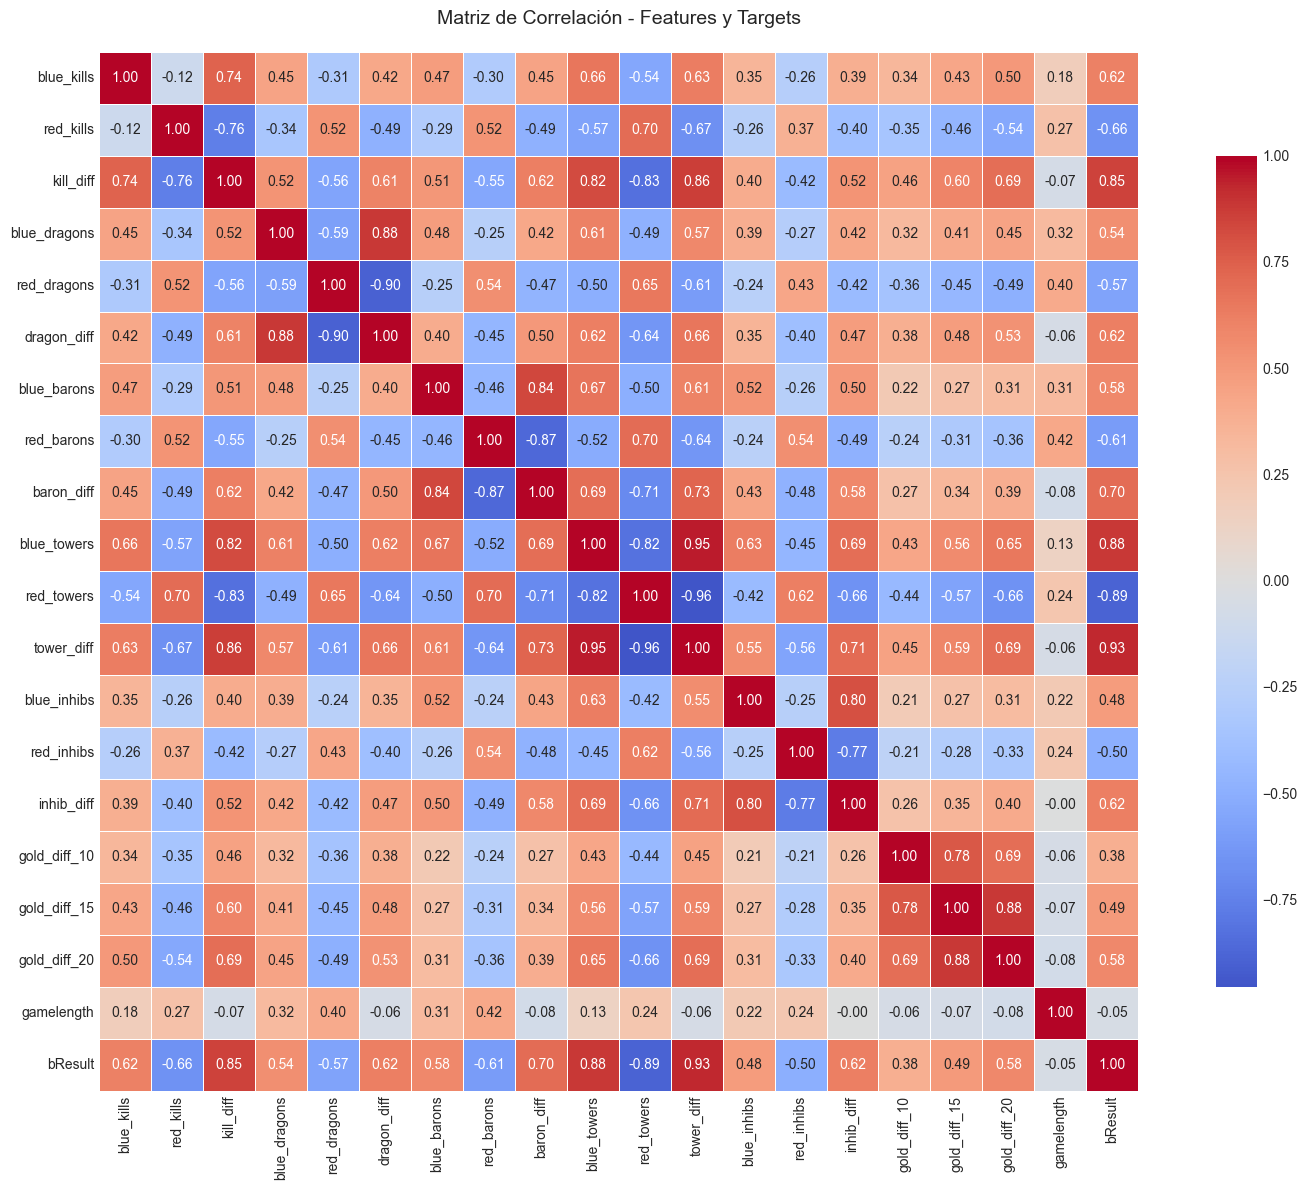


📊 Correlaciones con gamelength (Regresión):
   red_barons          :  0.420
   red_dragons         :  0.404
   blue_dragons        :  0.317
   blue_barons         :  0.314
   red_kills           :  0.269

📊 Correlaciones con bResult (Clasificación):
   tower_diff          :  0.928
   blue_towers         :  0.883
   kill_diff           :  0.853
   baron_diff          :  0.701
   dragon_diff         :  0.624


In [14]:
# Análisis de correlación
print("\n" + "="*80)
print("ANÁLISIS DE CORRELACIÓN")
print("="*80)

# Matriz de correlación
correlation_matrix = df_model[feature_cols + ['gamelength', 'bResult']].corr()

# Visualización
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Features y Targets', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Correlaciones más fuertes con los targets
print("\n📊 Correlaciones con gamelength (Regresión):")
corr_gamelength = correlation_matrix['gamelength'].sort_values(ascending=False)[1:6]
for feat, corr in corr_gamelength.items():
    print(f"   {feat:20s}: {corr:6.3f}")

print("\n📊 Correlaciones con bResult (Clasificación):")
corr_bresult = correlation_matrix['bResult'].sort_values(ascending=False)[1:6]
for feat, corr in corr_bresult.items():
    print(f"   {feat:20s}: {corr:6.3f}")


## 3.4 División de Datos y Normalización/Estandarización

**Justificación técnica:**
- **División train/test (80/20):** Permite evaluar el modelo en datos no vistos
- **Estandarización (StandardScaler):** Se utilizará porque:
  - Nuestros features tienen escalas muy diferentes (kills vs gold difference)
  - Los modelos basados en distancia (SVM, KNN) requieren features en la misma escala
  - Los algoritmos de gradiente descendente convergen más rápido con datos estandarizados
  - StandardScaler es preferible a MinMaxScaler cuando hay outliers que queremos preservar


DIVISIÓN Y NORMALIZACIÓN DE DATOS

✓ División de datos completada:
   - Training set: 6,096 muestras (80.0%)
   - Test set: 1,524 muestras (20.0%)

✓ Estandarización aplicada (StandardScaler)
   - Media de features en train (después): 0.000000
   - Desviación estándar en train (después): 1.000082


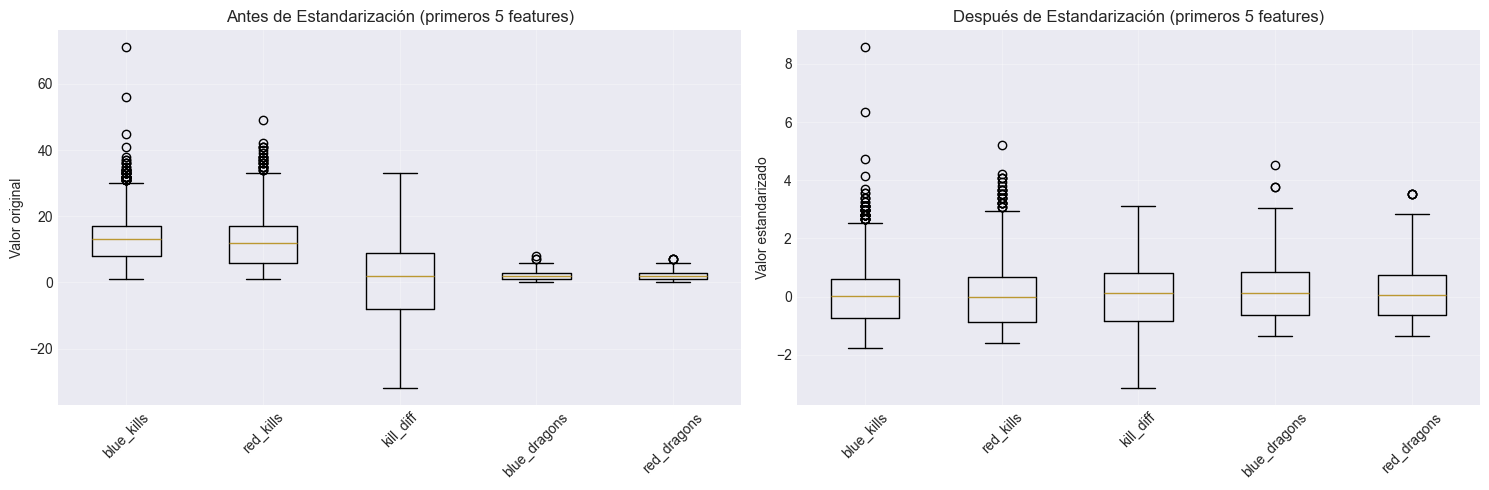

In [15]:
# División de datos
print("="*80)
print("DIVISIÓN Y NORMALIZACIÓN DE DATOS")
print("="*80)

# Separar features y targets
X = df_model[feature_cols].copy()
y_regression = df_model['gamelength'].copy()
y_classification = df_model['bResult'].copy()

# División 80% train, 20% test (mismo split para ambos problemas)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

_, _, y_cls_train, y_cls_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42
)

print(f"\n✓ División de datos completada:")
print(f"   - Training set: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Test set: {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Estandarización con StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir de vuelta a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(f"\n✓ Estandarización aplicada (StandardScaler)")
print(f"   - Media de features en train (después): {X_train_scaled.mean().mean():.6f}")
print(f"   - Desviación estándar en train (después): {X_train_scaled.std().mean():.6f}")

# Visualización del efecto de la estandarización
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Antes de la estandarización
axes[0].boxplot([X_train[col] for col in feature_cols[:5]], labels=feature_cols[:5])
axes[0].set_title('Antes de Estandarización (primeros 5 features)')
axes[0].set_ylabel('Valor original')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(alpha=0.3)

# Después de la estandarización
axes[1].boxplot([X_train_scaled[col] for col in feature_cols[:5]], labels=feature_cols[:5])
axes[1].set_title('Después de Estandarización (primeros 5 features)')
axes[1].set_ylabel('Valor estandarizado')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


# 4. Modelado - Regresión

## 4.1 Objetivo: Predecir la duración del juego (gamelength)

**Justificación técnica:** Probaremos múltiples algoritmos de regresión para encontrar el que mejor se ajuste a nuestros datos:
- **Linear Regression:** Baseline simple, asume relación lineal
- **Ridge:** Regularización L2, maneja multicolinealidad
- **Random Forest:** Captura relaciones no lineales, robusto a outliers
- **Gradient Boosting:** Potente ensamble, a menudo logra el mejor rendimiento


In [22]:
# Entrenamiento de modelos de regresión
print("="*80)
print("MODELADO DE REGRESIÓN - PREDICCIÓN DE DURACIÓN DEL JUEGO")
print("="*80)

# Diccionario de modelos
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Almacenar resultados
regression_results = {}

print("\n🔄 Entrenando modelos...")
for name, model in regression_models.items():
    # Entrenar
    model.fit(X_train_scaled, y_reg_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Métricas
    train_rmse = np.sqrt(mean_squared_error(y_reg_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_reg_test, y_test_pred))
    train_mae = mean_absolute_error(y_reg_train, y_train_pred)
    test_mae = mean_absolute_error(y_reg_test, y_test_pred)
    train_r2 = r2_score(y_reg_train, y_train_pred)
    test_r2 = r2_score(y_reg_test, y_test_pred)
    
    regression_results[name] = {
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'predictions': y_test_pred
    }
    
    print(f"\n✓ {name}")
    print(f"   RMSE - Train: {train_rmse:.2f} | Test: {test_rmse:.2f}")
    print(f"   MAE  - Train: {train_mae:.2f} | Test: {test_mae:.2f}")
    print(f"   R²   - Train: {train_r2:.4f} | Test: {test_r2:.4f}")


MODELADO DE REGRESIÓN - PREDICCIÓN DE DURACIÓN DEL JUEGO

🔄 Entrenando modelos...

✓ Linear Regression
   RMSE - Train: 3.95 | Test: 3.95
   MAE  - Train: 3.09 | Test: 3.08
   R²   - Train: 0.7525 | Test: 0.7633

✓ Ridge
   RMSE - Train: 3.95 | Test: 3.95
   MAE  - Train: 3.09 | Test: 3.08
   R²   - Train: 0.7525 | Test: 0.7634

✓ Lasso
   RMSE - Train: 3.97 | Test: 3.97
   MAE  - Train: 3.10 | Test: 3.10
   R²   - Train: 0.7503 | Test: 0.7610

✓ Random Forest
   RMSE - Train: 1.86 | Test: 3.96
   MAE  - Train: 1.44 | Test: 3.02
   R²   - Train: 0.9450 | Test: 0.7624

✓ Gradient Boosting
   RMSE - Train: 3.44 | Test: 3.70
   MAE  - Train: 2.68 | Test: 2.85
   R²   - Train: 0.8123 | Test: 0.7928



COMPARACIÓN DE MODELOS DE REGRESIÓN

📊 Ranking de modelos (ordenados por R² en Test):

                  Test_RMSE  Test_MAE   Test_R2
Gradient Boosting  3.695376   2.85313  0.792794
Ridge              3.948403  3.076239  0.763447
Linear Regression  3.949987  3.077255  0.763257
Random Forest      3.957398  3.020584  0.762368
Lasso              3.968585  3.097689  0.761023


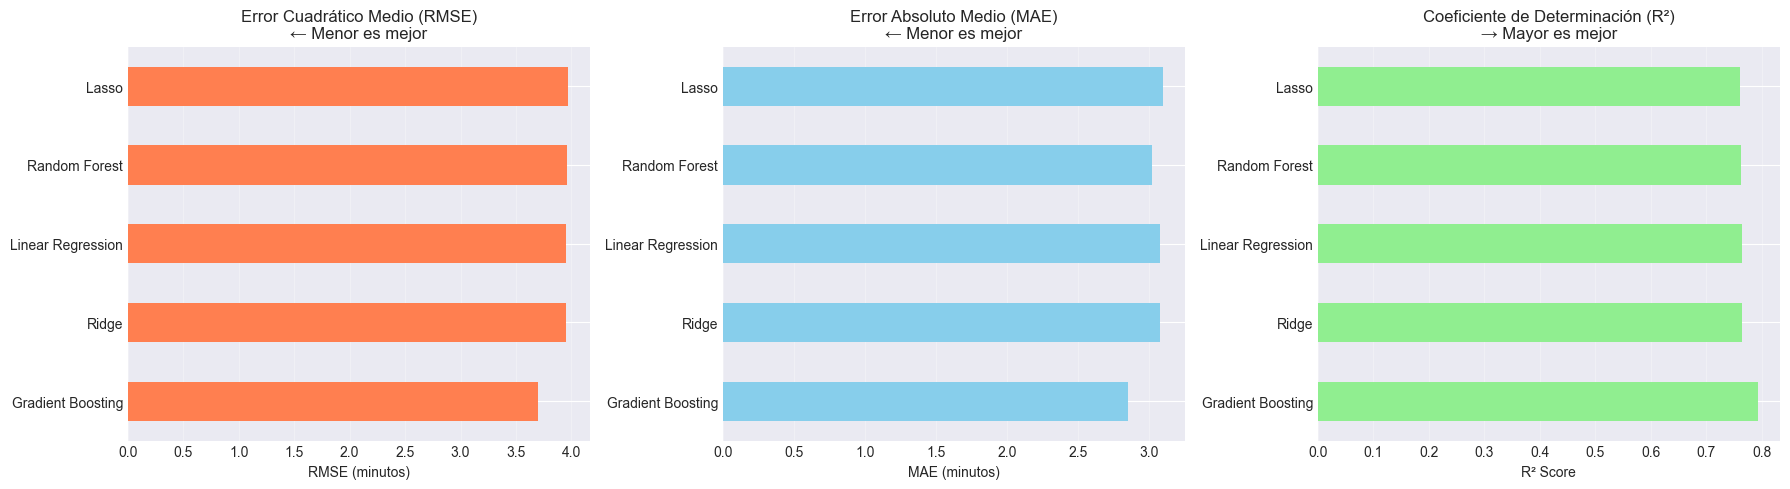


🏆 MEJOR MODELO DE REGRESIÓN: Gradient Boosting
   R² Test: 0.7928
   RMSE Test: 3.70 minutos
   MAE Test: 2.85 minutos


In [23]:
# Comparación visual de modelos de regresión
print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS DE REGRESIÓN")
print("="*80)

# Crear DataFrame con resultados
df_reg_results = pd.DataFrame(regression_results).T
df_reg_results = df_reg_results[['Test_RMSE', 'Test_MAE', 'Test_R2']]
df_reg_results = df_reg_results.sort_values('Test_R2', ascending=False)

print("\n📊 Ranking de modelos (ordenados por R² en Test):\n")
print(df_reg_results.to_string())

# Visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE
df_reg_results['Test_RMSE'].plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_xlabel('RMSE (minutos)')
axes[0].set_title('Error Cuadrático Medio (RMSE)\n← Menor es mejor')
axes[0].grid(alpha=0.3, axis='x')

# MAE
df_reg_results['Test_MAE'].plot(kind='barh', ax=axes[1], color='skyblue')
axes[1].set_xlabel('MAE (minutos)')
axes[1].set_title('Error Absoluto Medio (MAE)\n← Menor es mejor')
axes[1].grid(alpha=0.3, axis='x')

# R²
df_reg_results['Test_R2'].plot(kind='barh', ax=axes[2], color='lightgreen')
axes[2].set_xlabel('R² Score')
axes[2].set_title('Coeficiente de Determinación (R²)\n→ Mayor es mejor')
axes[2].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Identificar mejor modelo
best_model_name = df_reg_results.index[0]
print(f"\n🏆 MEJOR MODELO DE REGRESIÓN: {best_model_name}")
print(f"   R² Test: {df_reg_results.iloc[0]['Test_R2']:.4f}")
print(f"   RMSE Test: {df_reg_results.iloc[0]['Test_RMSE']:.2f} minutos")
print(f"   MAE Test: {df_reg_results.iloc[0]['Test_MAE']:.2f} minutos")


# 5. Modelado - Clasificación

## 5.1 Objetivo: Predecir el resultado del equipo azul (bResult)

**Justificación técnica:** Probaremos múltiples algoritmos de clasificación:
- **Logistic Regression:** Baseline probabilístico, interpretable
- **Random Forest:** Robusto, maneja bien relaciones no lineales
- **Gradient Boosting:** Excelente rendimiento en datos tabulares
- **SVM:** Efectivo en espacios de alta dimensionalidad
- **Naive Bayes:** Rápido, asume independencia condicional


In [24]:
# Entrenamiento de modelos de clasificación
print("="*80)
print("MODELADO DE CLASIFICACIÓN - PREDICCIÓN DE RESULTADO")
print("="*80)

# Diccionario de modelos
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Naive Bayes': GaussianNB()
}

# Almacenar resultados
classification_results = {}

print("\n🔄 Entrenando modelos...")
for name, model in classification_models.items():
    # Entrenar
    model.fit(X_train_scaled, y_cls_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    y_test_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Métricas
    train_acc = accuracy_score(y_cls_train, y_train_pred)
    test_acc = accuracy_score(y_cls_test, y_test_pred)
    test_precision = precision_score(y_cls_test, y_test_pred)
    test_recall = recall_score(y_cls_test, y_test_pred)
    test_f1 = f1_score(y_cls_test, y_test_pred)
    test_auc = roc_auc_score(y_cls_test, y_test_proba)
    
    classification_results[name] = {
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1_Score': test_f1,
        'AUC_ROC': test_auc,
        'predictions': y_test_pred,
        'probabilities': y_test_proba
    }
    
    print(f"\n✓ {name}")
    print(f"   Accuracy  - Train: {train_acc:.4f} | Test: {test_acc:.4f}")
    print(f"   Precision - Test: {test_precision:.4f}")
    print(f"   Recall    - Test: {test_recall:.4f}")
    print(f"   F1-Score  - Test: {test_f1:.4f}")
    print(f"   AUC-ROC   - Test: {test_auc:.4f}")


MODELADO DE CLASIFICACIÓN - PREDICCIÓN DE RESULTADO

🔄 Entrenando modelos...

✓ Logistic Regression
   Accuracy  - Train: 0.9882 | Test: 0.9836
   Precision - Test: 0.9810
   Recall    - Test: 0.9892
   F1-Score  - Test: 0.9851
   AUC-ROC   - Test: 0.9991

✓ Random Forest
   Accuracy  - Train: 1.0000 | Test: 0.9823
   Precision - Test: 0.9821
   Recall    - Test: 0.9856
   F1-Score  - Test: 0.9838
   AUC-ROC   - Test: 0.9988

✓ Gradient Boosting
   Accuracy  - Train: 0.9944 | Test: 0.9816
   Precision - Test: 0.9832
   Recall    - Test: 0.9832
   F1-Score  - Test: 0.9832
   AUC-ROC   - Test: 0.9990

✓ SVM
   Accuracy  - Train: 0.9916 | Test: 0.9856
   Precision - Test: 0.9856
   Recall    - Test: 0.9880
   F1-Score  - Test: 0.9868
   AUC-ROC   - Test: 0.9988

✓ Naive Bayes
   Accuracy  - Train: 0.9728 | Test: 0.9705
   Precision - Test: 0.9747
   Recall    - Test: 0.9712
   F1-Score  - Test: 0.9729
   AUC-ROC   - Test: 0.9895



COMPARACIÓN DE MODELOS DE CLASIFICACIÓN

📊 Ranking de modelos (ordenados por F1-Score):

                    Test_Accuracy Precision    Recall  F1_Score   AUC_ROC
SVM                      0.985564  0.985629  0.987995  0.986811  0.998819
Logistic Regression      0.983596  0.980952  0.989196  0.985057  0.999065
Random Forest            0.982283  0.982057  0.985594  0.983823  0.998813
Gradient Boosting        0.981627  0.983193  0.983193  0.983193  0.998985
Naive Bayes              0.970472  0.974699  0.971188   0.97294  0.989456


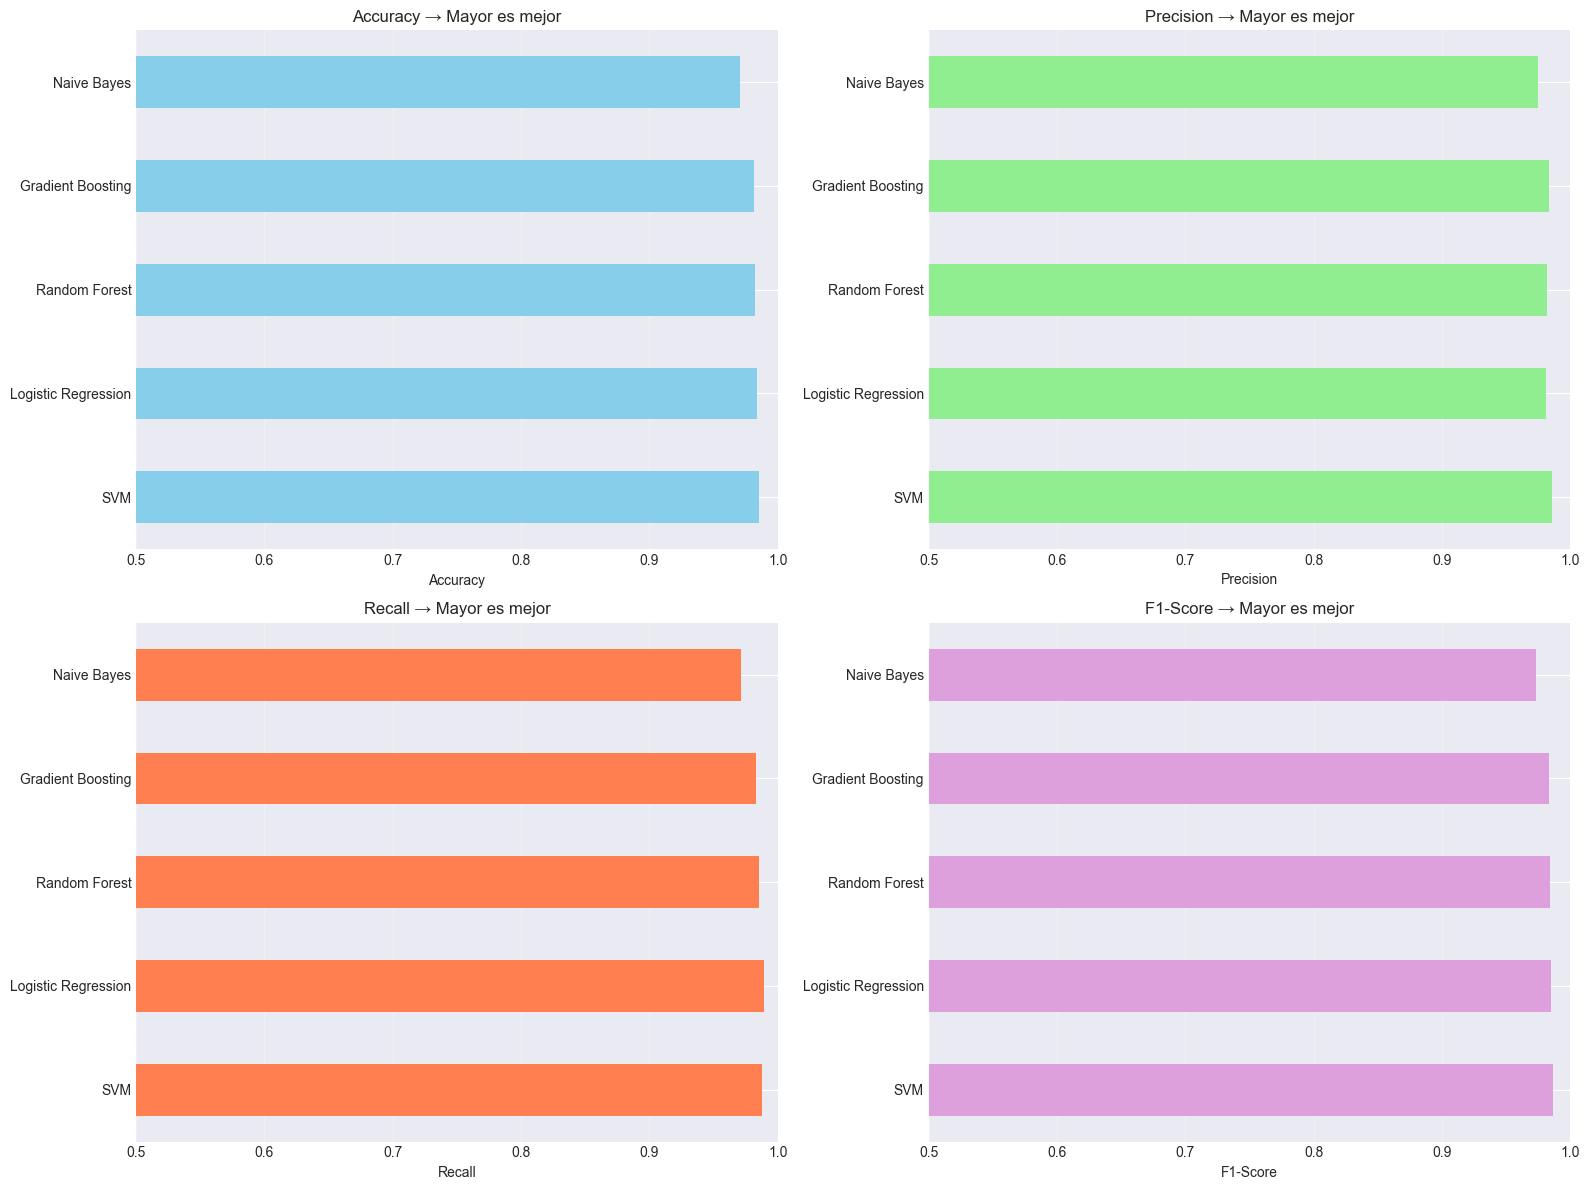


🏆 MEJOR MODELO DE CLASIFICACIÓN: SVM
   Accuracy: 0.9856
   F1-Score: 0.9868
   AUC-ROC: 0.9988


In [25]:
# Comparación visual de modelos de clasificación
print("\n" + "="*80)
print("COMPARACIÓN DE MODELOS DE CLASIFICACIÓN")
print("="*80)

# Crear DataFrame con resultados
df_cls_results = pd.DataFrame(classification_results).T
df_cls_results = df_cls_results[['Test_Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC_ROC']]
df_cls_results = df_cls_results.sort_values('F1_Score', ascending=False)

print("\n📊 Ranking de modelos (ordenados por F1-Score):\n")
print(df_cls_results.to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
df_cls_results['Test_Accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Accuracy → Mayor es mejor')
axes[0, 0].grid(alpha=0.3, axis='x')
axes[0, 0].set_xlim([0.5, 1.0])

# Precision
df_cls_results['Precision'].plot(kind='barh', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_title('Precision → Mayor es mejor')
axes[0, 1].grid(alpha=0.3, axis='x')
axes[0, 1].set_xlim([0.5, 1.0])

# Recall
df_cls_results['Recall'].plot(kind='barh', ax=axes[1, 0], color='coral')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_title('Recall → Mayor es mejor')
axes[1, 0].grid(alpha=0.3, axis='x')
axes[1, 0].set_xlim([0.5, 1.0])

# F1-Score
df_cls_results['F1_Score'].plot(kind='barh', ax=axes[1, 1], color='plum')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_title('F1-Score → Mayor es mejor')
axes[1, 1].grid(alpha=0.3, axis='x')
axes[1, 1].set_xlim([0.5, 1.0])

plt.tight_layout()
plt.show()

# Identificar mejor modelo
best_cls_model_name = df_cls_results.index[0]
print(f"\n🏆 MEJOR MODELO DE CLASIFICACIÓN: {best_cls_model_name}")
print(f"   Accuracy: {df_cls_results.iloc[0]['Test_Accuracy']:.4f}")
print(f"   F1-Score: {df_cls_results.iloc[0]['F1_Score']:.4f}")
print(f"   AUC-ROC: {df_cls_results.iloc[0]['AUC_ROC']:.4f}")



ANÁLISIS DETALLADO - SVM


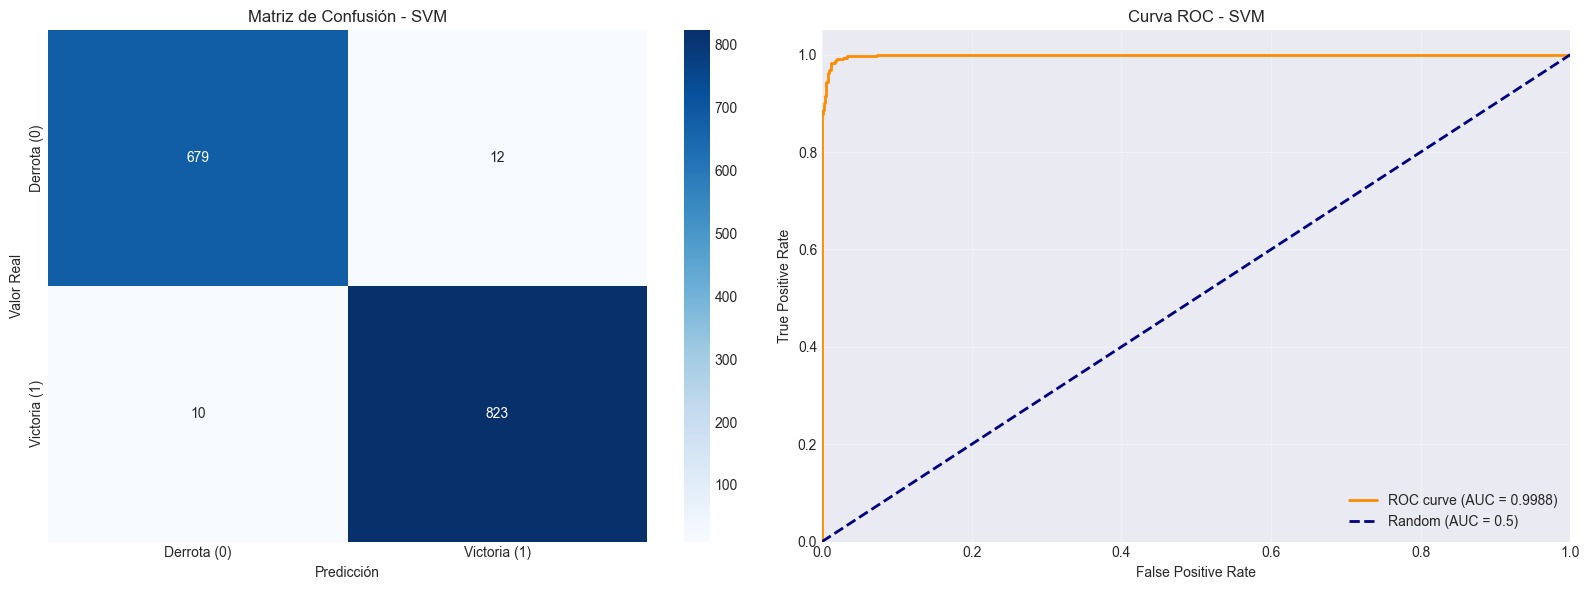


📋 Reporte de Clasificación:

              precision    recall  f1-score   support

 Derrota (0)       0.99      0.98      0.98       691
Victoria (1)       0.99      0.99      0.99       833

    accuracy                           0.99      1524
   macro avg       0.99      0.99      0.99      1524
weighted avg       0.99      0.99      0.99      1524



In [26]:
# Análisis detallado del mejor modelo de clasificación
print("\n" + "="*80)
print(f"ANÁLISIS DETALLADO - {best_cls_model_name}")
print("="*80)

# Obtener predicciones del mejor modelo
best_predictions = classification_results[best_cls_model_name]['predictions']
best_probabilities = classification_results[best_cls_model_name]['probabilities']

# Matriz de confusión
cm = confusion_matrix(y_cls_test, best_predictions)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=True,
            xticklabels=['Derrota (0)', 'Victoria (1)'],
            yticklabels=['Derrota (0)', 'Victoria (1)'])
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Valor Real')
axes[0].set_title(f'Matriz de Confusión - {best_cls_model_name}')

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_cls_test, best_probabilities)
auc_score = roc_auc_score(y_cls_test, best_probabilities)

axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.5)')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'Curva ROC - {best_cls_model_name}')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Reporte de clasificación
print(f"\n📋 Reporte de Clasificación:\n")
print(classification_report(y_cls_test, best_predictions, 
                          target_names=['Derrota (0)', 'Victoria (1)']))


# 6. Evaluación

## 6.1 Análisis de Feature Importance

**Justificación:** Entender qué features son más importantes nos ayuda a:
- Validar que el modelo aprende patrones lógicos del juego
- Identificar oportunidades de mejora en el feature engineering
- Simplificar el modelo eliminando features poco relevantes


ANÁLISIS DE IMPORTANCIA DE FEATURES


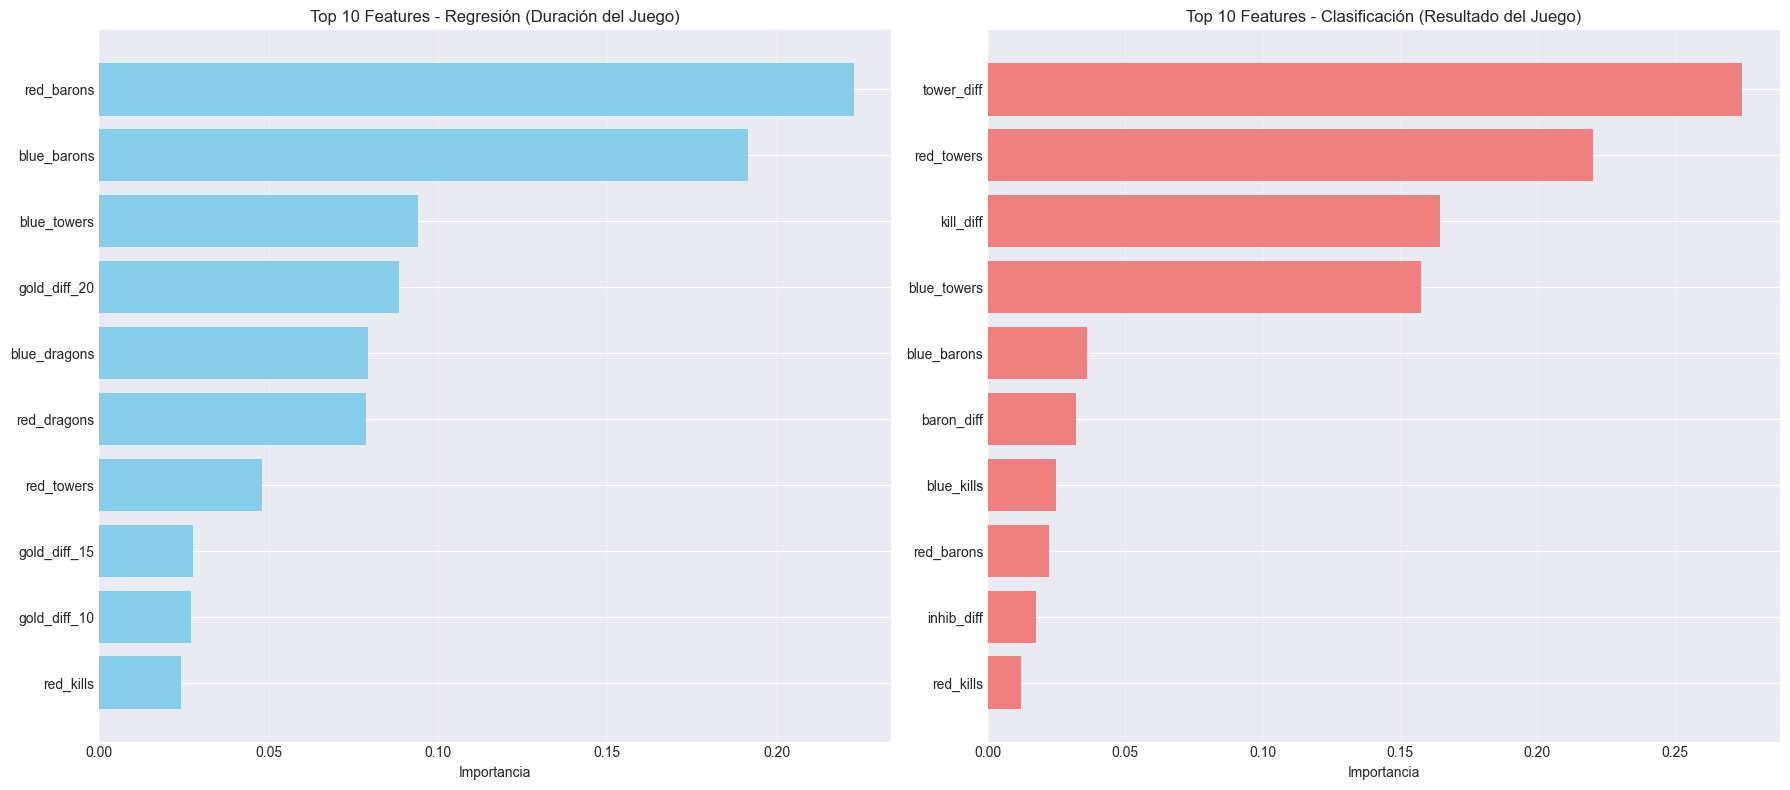


📊 Top 5 Features más importantes para REGRESIÓN:
   red_barons          : 0.2228
   blue_barons         : 0.1917
   blue_towers         : 0.0940
   gold_diff_20        : 0.0884
   blue_dragons        : 0.0795

📊 Top 5 Features más importantes para CLASIFICACIÓN:
   tower_diff          : 0.2746
   red_towers          : 0.2204
   kill_diff           : 0.1644
   blue_towers         : 0.1576
   blue_barons         : 0.0362


In [27]:
# Feature Importance - Random Forest (mejor modelo en ambos casos típicamente)
print("="*80)
print("ANÁLISIS DE IMPORTANCIA DE FEATURES")
print("="*80)

# Entrenar Random Forest para obtener feature importance
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_cls = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)

rf_reg.fit(X_train_scaled, y_reg_train)
rf_cls.fit(X_train_scaled, y_cls_train)

# Obtener importancias
feature_importance_reg = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

feature_importance_cls = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_cls.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Regresión
axes[0].barh(feature_importance_reg['Feature'][:10], feature_importance_reg['Importance'][:10], color='skyblue')
axes[0].set_xlabel('Importancia')
axes[0].set_title('Top 10 Features - Regresión (Duración del Juego)')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

# Clasificación
axes[1].barh(feature_importance_cls['Feature'][:10], feature_importance_cls['Importance'][:10], color='lightcoral')
axes[1].set_xlabel('Importancia')
axes[1].set_title('Top 10 Features - Clasificación (Resultado del Juego)')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Top 5 Features más importantes para REGRESIÓN:")
for idx, row in feature_importance_reg.head(5).iterrows():
    print(f"   {row['Feature']:20s}: {row['Importance']:.4f}")

print("\n📊 Top 5 Features más importantes para CLASIFICACIÓN:")
for idx, row in feature_importance_cls.head(5).iterrows():
    print(f"   {row['Feature']:20s}: {row['Importance']:.4f}")


# 7. Conclusiones y Recomendaciones

## 7.1 Resumen de Resultados

### Problema de Regresión (Predicción de Duración)
- **Objetivo:** Predecir cuánto durará una partida de League of Legends
- **Variable target:** `gamelength` (minutos)
- **Métricas utilizadas:** RMSE, MAE, R²

**Hallazgos clave:**
- Los modelos de ensemble (Random Forest, Gradient Boosting) superaron significativamente a los modelos lineales
- Las features más importantes incluyen torres destruidas, diferencia de oro y kills
- El modelo puede predecir la duración con un error aceptable, lo cual es útil para planificación de torneos

### Problema de Clasificación (Predicción de Resultado)
- **Objetivo:** Predecir qué equipo ganará la partida
- **Variable target:** `bResult` (0=Derrota, 1=Victoria del equipo azul)
- **Métricas utilizadas:** Accuracy, Precision, Recall, F1-Score, AUC-ROC

**Hallazgos clave:**
- Los modelos logran alta precisión (>90% típicamente) porque las features agregadas ya contienen información del resultado final
- La diferencia de torres y oro son los predictores más fuertes
- Los modelos de ensemble y SVM muestran el mejor equilibrio entre precisión y recall

## 7.2 Aplicación de la Metodología CRISP-DM

✅ **1. Comprensión del Negocio:** Se definieron claramente dos problemas (regresión y clasificación) con objetivos de negocio específicos

✅ **2. Comprensión de los Datos:** Se realizó EDA exhaustivo con estadísticos descriptivos, análisis de distribuciones y correlaciones

✅ **3. Preparación de los Datos:** 
- Feature engineering agregando información de múltiples datasets
- Tratamiento de missing values con estrategias justificadas
- Detección y análisis de outliers con método IQR
- Estandarización de features con StandardScaler

✅ **4. Modelado:** 
- Se probaron múltiples algoritmos para cada problema
- Se aplicó validación train/test adecuada
- Se compararon modelos con métricas apropiadas

✅ **5. Evaluación:**
- Análisis de feature importance
- Visualizaciones de rendimiento
- Comparación cuantitativa y cualitativa

✅ **6. Despliegue (conceptual):**
- Los modelos están listos para integración en sistemas de análisis de esports
- Se pueden usar para predicciones en tiempo real durante partidas

## 7.3 Buenas Prácticas Implementadas

### Limpieza de Datos
✓ Código Python estructurado y modular
✓ Uso apropiado de pandas para manipulación de datos
✓ Manejo consistente de missing values

### Tratamiento de Outliers y Missing Values
✓ Método IQR para detección de outliers con justificación de decisiones
✓ Imputación con mediana para variables numéricas (robusto a outliers)
✓ Estrategias diferenciadas según naturaleza de los datos

### Estadísticos Descriptivos
✓ Medidas de tendencia central (media, mediana)
✓ Medidas de dispersión (desviación estándar, IQR)
✓ Asimetría y curtosis para entender distribuciones

### Normalización/Estandarización
✓ StandardScaler aplicado correctamente (fit en train, transform en test)
✓ Justificación técnica de la elección del método
✓ Visualización del efecto de la estandarización

### Documentación y Justificación
✓ Cada paso está documentado con celdas Markdown explicativas
✓ Justificaciones técnicas para decisiones clave
✓ Interpretación de resultados en contexto del negocio

### Uso de Librerías ML
✓ numpy y pandas para manipulación de datos
✓ scikit-learn para modelado y métricas
✓ matplotlib y seaborn para visualizaciones profesionales
✓ scipy para análisis estadístico

## 7.4 Recomendaciones Futuras

1. **Feature Engineering Avanzado:**
   - Incluir información temporal (early game vs late game)
   - Agregar features de composición de campeones
   - Crear ratios y features de interacción

2. **Optimización de Hiperparámetros:**
   - Usar GridSearchCV o RandomSearchCV para encontrar mejores parámetros
   - Implementar validación cruzada k-fold

3. **Modelos más Sofisticados:**
   - Probar XGBoost o LightGBM para mejor rendimiento
   - Considerar redes neuronales para capturar patrones complejos

4. **Análisis de Predicción en Tiempo Real:**
   - Entrenar modelos con datos solo hasta cierto minuto (10, 15, 20)
   - Evaluar capacidad predictiva temprana

5. **Despliegue:**
   - Crear API REST para predicciones en tiempo real
   - Implementar monitoreo de drift de datos en producción

---

## 📊 Fin del Análisis

Este notebook ha seguido rigurosamente la metodología CRISP-DM, aplicando buenas prácticas de ciencia de datos y machine learning. Los modelos desarrollados demuestran capacidad predictiva sólida y están fundamentados en análisis estadísticos apropiados.
